In [57]:
import os
import sys
from time import time,sleep
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import networkx as nx
import random
import shutil

from keras import layers, models, optimizers
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

from utils import combine_images
from utils import plot_log

from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
sys.path.append('./PatchyTools/')
from GraphConverter import GraphConverter
from DropboxLoader import DropboxLoader
from CapsuleParameters import CapsuleParameters
from CapsuleParameters import CapsuleTrainingParameters
from GraphClassifier import GraphClassifier

import igraph as ig

import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Functions:

def get_nodes_per_graph(adj_dict):
    list_num_nodes = []
    for i in adj_dict.keys():
        list_num_nodes.append(len(adj_dict[i]['from'].unique()))
        
    return list_num_nodes

### Load data

In [60]:
# Getting the data:
dataset_name = 'DD'
width = 284
receptive_field = 10

In [61]:
# Get Tensor and Labels:
PatchyConverter = GraphConverter(dataset_name, width, receptive_field)
#PatchyConverter.relabel_graphs()
graph_tensor = PatchyConverter.graphs_to_Patchy_tensor()

# Getting the labels:
dropbox_loader = DropboxLoader(dataset_name)
labels = dropbox_loader.get_graph_label()
graph_labels = np.array(labels.graph_label)
graph_labels = pd.get_dummies(graph_labels)

DD tensor exists, loading it from Dropbox


In [62]:
# Importing graph features:
#df_edge_label = dropbox_loader.get_edge_label()
df_graph_ind = dropbox_loader.get_graph_ind()
df_adj = dropbox_loader.get_adj()
df_node_label = dropbox_loader.get_node_label()
df_node_label = pd.concat([df_node_label, df_graph_ind.graph_ind], axis=1)

In [63]:
# Mutag:
# Label Types:
neg,pos = sorted(graph_labels.columns.tolist())

# Labels:
label_col_name = 'label'
df_labels=pd.DataFrame(labels.values,columns=[label_col_name])
idx_pos = list(np.array(df_labels[df_labels[label_col_name]==pos].index.tolist())+1)
print('number of positive graphs: {}'.format(len(idx_pos)))
idx_neg = list(np.array(df_labels[df_labels[label_col_name]==neg].index.tolist())+1)
print('number of negatives graphs: {}'.format(len(idx_neg)))

number of positive graphs: 487
number of negatives graphs: 691


In [64]:
# Subsampling
n_sub = 5
subs_pos = random.sample(idx_pos,n_sub)
subs_neg = random.sample(idx_neg,n_sub)

In [65]:
# Adjeceny dict and 
adj_dict = PatchyConverter.create_adj_dict_by_graphId()
adj_coomatrix_by_graphId = PatchyConverter.create_adj_coomatrix_by_graphId(adj_dict)

In [66]:
feature_list = df_node_label['label'].unique()
nodes_features = pd.get_dummies(df_node_label.label,
                                columns=feature_list,
                                sparse=True)
nodes_features = nodes_features.T.reindex(feature_list).T.fillna(0)

### 1. Graph Visualization:

In [67]:
num_pos = len(subs_pos)
num_neg = len(subs_neg)

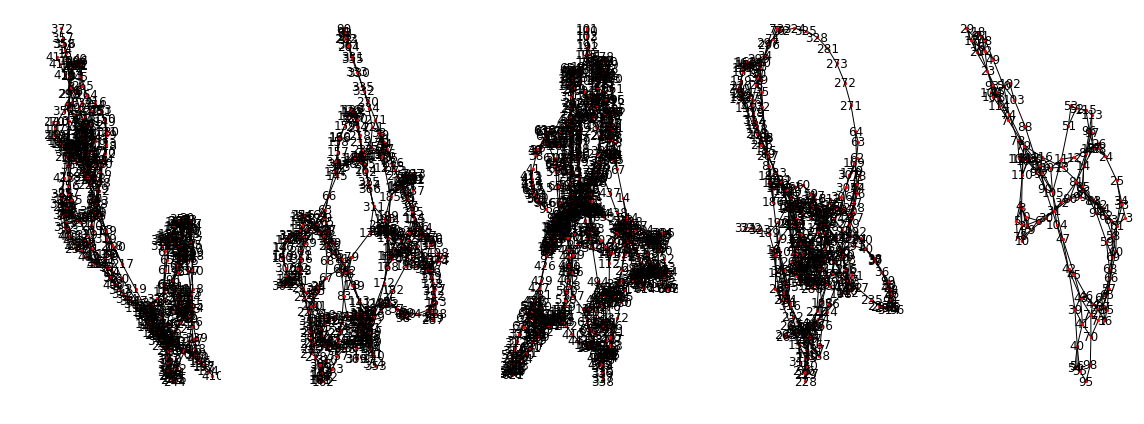

In [68]:
# rendering
#idx_to_draw = idx_neg
idx_to_draw = subs_neg
num_idx = len(idx_to_draw)
cols = 5
rows = int(num_idx/cols)

fig = plt.figure(1,figsize=(16,6))
fig.suptitle("Negative Graph Examples")
plt.clf()
# compute a grid size that will fit all graphs on it (couple blanks likely)
#nr = int(np.ceil(np.sqrt(len(indices))))

fig, ax = plt.subplots(rows,cols, num=1,squeeze=False)


for i,j in enumerate(idx_to_draw):
    ix = np.unravel_index(i, ax.shape)
    graph_edge_list = adj_dict[j]
    G = nx.Graph()
    G.add_edges_from(graph_edge_list.values)
    pos = nx.spring_layout(G, iterations=500)
    #plt.figure(figsize=(20,10))
    nx.draw(G,pos,with_labels=True,ax=ax[ix],node_size=5)

plt.tight_layout()
#plt.savefig('negative_graphs.png')
    

In [69]:
def plot_3D(adj_list,df_node_label,title='Graph'):
    # Importing libs:
    import plotly.plotly as py
    import plotly.graph_objs as go
    import plotly
    
    # Copy to Newtwork x:
    graph1 =nx.Graph()
    graph1.add_edges_from(adj_list.values)
    N = graph1.number_of_nodes()
    L = graph1.number_of_edges()
    Edges = [tuple(i) for i in adj_list.values]
    G=ig.Graph(Edges, directed=True)
    # Node labels:
    group = df_node_label['label'].tolist()
    # Setting plotly
    layt=G.layout('kk', dim=3) 
    
    Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
    Yn=[layt[k][1] for k in range(N)]# y-coordinates
    Zn=[layt[k][2] for k in range(N)]# z-coordinates
    Xe=[]
    Ye=[]
    Ze=[]
    for e in Edges:
        Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
        Ye+=[layt[e[0]][1],layt[e[1]][1], None]  
        Ze+=[layt[e[0]][2],layt[e[1]][2], None]  
        
    # PArameters:
    trace1=go.Scatter3d(x=Xe,
                   y=Ye,
                   z=Ze,
                   mode='lines',
                   line=dict(color='rgb(125,125,125)', width=1),
                   hoverinfo='none'
                   )

    trace2=go.Scatter3d(x=Xn,
                   y=Yn,
                   z=Zn,
                   mode='markers',
                   name='actors',
                   marker=dict(symbol='circle',
                                 size=6,
                                 color=group,
                                 colorscale='Viridis',
                                 line=dict(color='rgb(50,50,50)', width=0.5)
                                 ),
                   text=group,
                   hoverinfo='text'
                   )

    axis=dict(showbackground=False,
              showline=False,
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title=''
              )

    layout = go.Layout(
             title=title,
             width=1000,
             height=1000,
             showlegend=False,
             scene=dict(
                 xaxis=dict(axis),
                 yaxis=dict(axis),
                 zaxis=dict(axis),
            ),
         margin=dict(
            t=100
        ),
        hovermode='closest',
        annotations=[
               dict(
               showarrow=False,
                text="Data source: {}".format(title),
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=dict(
                size=14
                )
                )
            ],    )
    
    data=[trace1, trace2]
#     plotly.offline.plot({'data': data, 'layout': layout},
#              auto_open=True, image = 'png', image_filename='graph',
#              output_type='file', image_width=800, image_height=600, 
#              filename='temp-plot.html', validate=False)
    
    dload = os.path.expanduser('~/Downloads')
    title_png = title+'.png'
    f_load = os.path.join(dload,title_png)
    f_save = os.path.join('/Users/marcelogutierrez/Projects/Gamma/capsuleSans/diagrams',title_png)
    html_file = '{}.html'.format(title)
    
    plotly.offline.plot(
        {"data": data,
         "layout": layout},image='png',filename =html_file, image_filename=title, auto_open=True)
    
    sleep(3)

    shutil.move(f_load,f_save)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



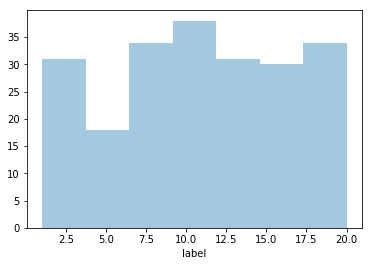

In [143]:
index = idx_neg[46]
test_adj = adj_dict[index]
test_node_labels = df_node_label[df_node_label.graph_ind==index]
#plot_3D(test_adj,test_node_labels,title='graph_{}'.format(dataset_name))
#import seaborn as sns
sns.distplot(test_node_labels.label,kde = False, rug = False )

In [ ]:
neg_nodes = []
for i,j in enumerate(idx_neg):
    G = nx.Graph()
    G.add_edges_from(adj_dict[j].values)
    neg_nodes.append(len(G.nodes))
print('average: ',np.mean(neg_nodes))
plt.hist(neg_nodes,bins=50)

In [ ]:
pos_nodes = []
for i,j in enumerate(idx_pos):
    G = nx.Graph()
    G.add_edges_from(adj_dict[j].values)
    pos_nodes.append(len(G.nodes))
print('average: ',np.mean(pos_nodes))
plt.hist(pos_nodes,bins=50)

In [ ]:
# rendering
#idx_to_draw = idx_pos
idx_to_draw = subs_pos
num_idx = len(idx_to_draw)
nr = int(np.ceil(np.sqrt(num_idx)))

fig = plt.figure(1,figsize=(24,48))
plt.clf()
# compute a grid size that will fit all graphs on it (couple blanks likely)
#nr = int(np.ceil(np.sqrt(len(indices))))

fig, ax = plt.subplots(rows,cols, num=1)


for i,j in enumerate(idx_to_draw):
    ix = np.unravel_index(i, ax.shape)
    graph_edge_list = adj_dict[j]
    G = nx.Graph()
    G.add_edges_from(graph_edge_list.values)
    pos = nx.spring_layout(G, iterations=50)
    #plt.figure(figsize=(20,10))
    nx.draw(G,pos,with_labels=True,ax=ax[ix],node_size=3)
    

#plt.savefig('positive_graphs.png')
    

### 2. Canonical Labelling

In [ ]:
from GraphConverter import dfadj_to_dict
from collections import defaultdict
import pynauty as nauty
from time import time
def dfadj_to_dict2(df_adj):
    '''
    input: edges and labels
    output: dictionary. key is node_id and value is list of nodes which the node_id connects to with edges.
    '''
    unique_nodes = np.unique( df_adj['from'].unique().tolist() + df_adj['to'].unique().tolist())
    graph =defaultdict(list)
    for key in unique_nodes:
        graph[key] += df_adj.loc[df_adj['from']==key]['to'].values.tolist()
        #graph[key] += df_adj.loc[df_adj['to']==key]['from'].values.tolist()
    return graph

In [ ]:
all_canonical_labels = []
all_canonical_labels2 = []
for key in adj_dict.keys():
    df_subset = df_node_label[df_node_label.graph_ind == key]
    start = time()
    temp_graph_dict = dfadj_to_dict(adj_dict[key])
    nauty_graph = nauty.Graph(len(temp_graph_dict), adjacency_dict=temp_graph_dict)
    canonical_labeling = nauty.canonical_labeling(nauty_graph)
    break
#     canonical_labeling = [df_subset.label.values[i] for i in canonical_labeling]  ###
#     all_canonical_labels += canonical_labeling
#     #print('time 1 : {}'.format(time()-start))
#     start = time()
#     temp_graph_dict2 = dfadj_to_dict2(adj_dict[key])
#     nauty_graph2 = nauty.Graph(len(temp_graph_dict2), adjacency_dict=temp_graph_dict2)
#     canonical_labeling2=nauty.canonical_labeling(nauty_graph2)
#     canonical_labeling2 = [df_subset.label.values[i] for i in canonical_labeling2]  ###
#     all_canonical_labels2 += canonical_labeling2
#     #print('time 1 : {}'.format(time()-start))

In [ ]:
canonical_labeling

In [ ]:
cano_label= [df_subset.label.values[i] for i in canonical_labeling]  ###

In [ ]:
pd.concat([df_subset, pd.Series(cano_label, dtype=int, name='cano_label')], axis=1)

In [ ]:
x = nx.Graph()

In [ ]:
x.add_edges_from(adj_dict[1].values)

In [ ]:
nx.draw_networkx(x)

In [ ]:
label_dict= {}
for i,j in df_subset[['label','node']].values:
    label_dict[j] = i

In [ ]:
nx.set_node_attributes(x, label_dict, 'feature')

In [ ]:
nx.draw_networkx(x)

In [ ]:
x

In [ ]:
list(x.neighbors(4))

In [ ]:
adj_list = adj_dict[1]

In [ ]:
adj_list[(adj_list['from']==4) | (adj_list['to']==4)]

In [ ]:
df_node_label.shape

In [ ]:
adj_dict_by_graphId= PatchyConverter.create_adj_dict_by_graphId()
#adj_coomatrix_by_graphId = self.create_adj_coomatrix_by_graphId(self.adj_dict_by_graphId)
#print('Canonical Labeling')
cano_label = PatchyConverter.canonical_labeling(adj_dict_by_graphId)
PatchyConverter.df_node_label = pd.concat([PatchyConverter.df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')], axis=1)
print('Getting the Neighboors ')
#neighbor_matrix = self.get_neighbor_matrix(adj_coomatrix_by_graphId)

In [ ]:
adj_coomatrix_by_graphId =  PatchyConverter.create_adj_coomatrix_by_graphId(adj_dict_by_graphId)

In [ ]:
neighbor_matrix = PatchyConverter.get_neighbor_matrix(adj_coomatrix_by_graphId)

In [ ]:
neighbor_matrix[0]

In [ ]:

# rendering
fig = plt.figure(1); plt.clf()
# compute a grid size that will fit all graphs on it (couple blanks likely)
nr = int(np.ceil(np.sqrt(len(indices))))
fig, ax = plt.subplots(nr, nr, num=1)


g1 = nx.Graph()
g1.add_edges_from(adj_1.values)
nx.draw(g1,pos,with_labels=True,)

In [ ]:
nauty_graph = nauty.Graph(len(temp_graph_dict), adjacency_dict=temp_graph_dict)
test_canon_label = nauty.canonical_labeling(nauty_graph)

In [ ]:
test_2 = [df_subset_nodes.label.values[i] for i in test_canon_label]  ###

In [ ]:
test_canon_label

In [ ]:
nodes_features.head()

In [ ]:
test_2

In [ ]:
df_node_label2 = pd.concat([df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')], axis=1)


In [ ]:
unique_graph_labels = df_node_label.graph_ind.unique()


In [ ]:
adjacency = adj_coomatrix_by_graphId[1]
graph = nx.from_numpy_matrix(adjacency.todense())

# Create the neighbors with -1 for neighbor assemble.
#After this, if the RECEPTIVE_FIELD_SIZE_K exceeds the number of WIDTH_W, then fill them with -1
neighborhoods = np.zeros((18, 10), dtype=np.int32)
neighborhoods.fill(-1)

df_sequence = df_node_label[df_node_label.graph_ind == 1]
df_sequence = df_sequence.sort_values(by='cano_label')
smallest_node_id = df_sequence.node.min()

# CUT GRAPH BY THRESHOLD of cano_label ''' Top width w elements of V according to labeling  '''
df_sequence = df_sequence.iloc[:18,:]
df_sequence['node'] = df_sequence.node.values  - smallest_node_id


In [ ]:
df_sequence

In [ ]:
df_shortest = pd.DataFrame.from_dict(nx.single_source_dijkstra_path_length(graph, 8),orient='index') #

In [ ]:
RECEPTIVE_FIELD_SIZE_K =10

In [ ]:
df_shortest.columns =['distance'] #
df_shortest['node'] = df_shortest.index.values #
df_shortest = pd.merge(df_node_label, df_shortest, on='node', how='right') #

In [ ]:
# Sort by distance and then by cano_label
df_shortest = df_shortest.sort_values(by=['distance','cano_label']) #
df_shortest = df_shortest.iloc[:10,:] #

In [ ]:
for j in range(0, min(RECEPTIVE_FIELD_SIZE_K, len(df_shortest))):
    #neighborhoods[i][j] = shortest[j][0]
    neighborhoods[8][j] = df_shortest['node'].values[j] + smallest_node_id


In [ ]:
df_sequence


In [ ]:
WIDTH_W = 18

In [ ]:
unique_graph_labels = df_node_label.graph_ind.unique()
for l_ind, l in zip([0],[1]):#enumerate(unique_graph_labels):
    adjacency = adj_coomatrix_by_graphId[l]
    graph = nx.from_numpy_matrix(adjacency.todense())

    # Create the neighbors with -1 for neighbor assemble.
    #After this, if the RECEPTIVE_FIELD_SIZE_K exceeds the number of WIDTH_W, then fill them with -1
    neighborhoods = np.zeros((WIDTH_W, RECEPTIVE_FIELD_SIZE_K), dtype=np.int32)
    neighborhoods.fill(-1)

    df_sequence = df_node_label[df_node_label.graph_ind == l]
    df_sequence = df_sequence.sort_values(by='cano_label')
    smallest_node_id = df_sequence.node.min()

    # CUT GRAPH BY THRESHOLD of cano_label ''' Top width w elements of V according to labeling  '''
    df_sequence = df_sequence.iloc[:WIDTH_W,:]
    df_sequence['node'] = df_sequence.node.values  - smallest_node_id

    for i, node in enumerate(df_sequence.node):
        #shortest = nx.single_source_dijkstra_path_length(graph, node).items()
        df_shortest = pd.DataFrame.from_dict(nx.single_source_dijkstra_path_length(graph, node),
                                             orient='index') #
        df_shortest.columns =['distance'] #
        df_shortest['node'] = df_shortest.index.values #
        df_shortest = pd.merge(df_node_label, df_shortest, on='node', how='right') #

        # Sort by distance and then by cano_label
        df_shortest = df_shortest.sort_values(by=['distance','cano_label']) #
        df_shortest = df_shortest.iloc[:RECEPTIVE_FIELD_SIZE_K,:] #
        #shortest = sorted(shortest, key=lambda v: v[1])
        #shortest = shortest[:RECEPTIVE_FIELD_SIZE_K]
        for j in range(0, min(RECEPTIVE_FIELD_SIZE_K, len(df_shortest))):
            #neighborhoods[i][j] = shortest[j][0]
            neighborhoods[i][j] = df_shortest['node'].values[j] + smallest_node_id

    #neighborhoods_dict[l]= neighborhoods.copy()
    if l_ind ==0:
        neighborhoods_all = neighborhoods
    else:
        neighborhoods_all = np.r_[neighborhoods_all, neighborhoods]

In [ ]:
# Getting the adj matrix and the nodes:
df_subset_adj = adj_dict[1]
df_subset_nodes = df_node_label[df_node_label.graph_ind==1]

In [ ]:
temp_graph_dict = dfadj_to_dict(df_subset_adj)
temp_graph_dict

In [ ]:
adj_dict_by_graphId = create_adj_dict_by_graphId(df_adj, df_node_label)
adj_coomatrix_by_graphId = create_adj_coomatrix_by_graphId(adj_dict_by_graphId, df_node_label)

In [ ]:
df_node_label = pd.concat([df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')], axis=1)

In [ ]:
neighborhoods_graph = make_neighbor(adj_coomatrix_by_graphId, df_node_label, WIDTH_W=18, RECEPTIVE_FIELD_SIZE_K=10)

In [ ]:
neighborhoods_graph

In [ ]:
len(df_node_label.graph_ind.unique())

In [ ]:
df_node_label.graph_ind.unique()

In [ ]:



df_node_label = pd.concat([df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')], axis=1)

neighborhoods_graph = make_neighbor(adj_coomatrix_by_graphId, df_node_label, WIDTH_W=WIDTH_W, RECEPTIVE_FIELD_SIZE_K=RECEPTIVE_FIELD_SIZE_K)
result_tensor = tensor(neighborhoods_graph, WIDTH_W, RECEPTIVE_FIELD_SIZE_K, df_node_label)

In [ ]:
idx_ranges = np.cumsum([0] + df_graph_ind.groupby('graph_ind').count().node.tolist())

In [ ]:
graph_idx = 4
list_nodes_per_graph = list(range(idx_ranges[graph_idx],idx_ranges[graph_idx+1]))
adj_1 = df_adj[df_adj['from'].isin(list_nodes_per_graph) | df_adj['to'].isin(list_nodes_per_graph)]

In [ ]:
g1 = nx.Graph()
g1.add_edges_from(adj_1.values)
nx.draw(g1)

In [ ]:
num_features = len(df_node_label.label.unique())
print('number of features : {}'.format(num_features))
data_in_patchysan = Patchy_san.main(WIDTH_W=18, RECEPTIVE_FIELD_SIZE_K=10, datasetname='MUTAG')
data_in_patchysan.shape[3]
#final_labels = mutag.get_graph_label().graph_label.values
#final_labels = pd.get_dummies(final_labels).values

In [ ]:
dataset_name = 'MUTAG'
GAMMA_ENV = os.environ['GAMMA_DATA_ROOT']
root_gamma_path = GAMMA_ENV+'Samples'
node_label_filename =  '{0}/{0}_node_labels.txt'.format(dataset_name)
node_label_path = os.path.join(root_gamma_path, node_label_filename)
pd.read_csv(node_label_path , delimiter=' ',header=None,index_col=None)

### Functions

In [ ]:

def get_subset_adj(df_adj, df_node_label,graph_label_num):
    df_glabel = df_node_label[df_node_label.graph_label == graph_label_num ]
    index_of_glabel = (df_adj['to'].isin(df_glabel.node) & df_adj['from'].isin(df_glabel.node))
    return df_adj[index_of_glabel]

def get_smallest_node_id_from_adj(df_adj):
    return min(df_adj['to'].min(), df_adj['from'].min())


def create_adj_dict_by_graphId(df_adj, df_node_label):
    '''
    input: df_node_label
    return: {1: {0:[0,2,5]}} = {graphId: {nodeId:[node,node,node]}}
    '''
    adj_dict_by_graphId ={}
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = get_subset_adj(df_adj, df_node_label, graph_label_num=l)        
        smallest_node_id = get_smallest_node_id_from_adj(df_subset_adj)
        df_subset_adj -= smallest_node_id
        adj_dict_by_graphId[l] = df_subset_adj
    return adj_dict_by_graphId


def canonical_labeling(adj_dict_by_graphId, df_node_label, df_adj):
    all_canonical_labels =[]
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = adj_dict_by_graphId[l]
        df_subset_nodes = df_node_label[df_node_label.graph_label==l]        
        temp_graph_dict = utils.dfadj_to_dict(df_subset_adj)
        nauty_graph = nauty.Graph(len(temp_graph_dict), adjacency_dict=temp_graph_dict)
        canonical_labeling = nauty.canonical_labeling(nauty_graph)        
        canonical_labeling = [df_subset_nodes.label.values[i] for i in canonical_labeling] ###
        all_canonical_labels += canonical_labeling
    return all_canonical_labels


def create_adj_coomatrix_by_graphId(adj_dict_by_graphId, df_node_label):
    """
    return: a coomatrix per graphId
    """
    
    adj_coomatrix_by_graphId ={}
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = adj_dict_by_graphId[l]
        df_subset_node_label = df_node_label[df_node_label.graph_label == l]
        adjacency = coo_matrix(( np.ones(len(df_subset_adj)), 
                                (df_subset_adj.iloc[:,0].values, df_subset_adj.iloc[:,1].values) ), 
                                 shape=(len(df_subset_node_label), len(df_subset_node_label))
                              )
        adj_coomatrix_by_graphId[l]=adjacency
    return adj_coomatrix_by_graphId

def make_neighbor(adj_coomatrix_by_graphId, df_node_label, WIDTH_W):
    
    """
    return: a dictionary with the shape of {graphId:[matrix: node x neighbor]} 
    The size of 2D matrix is (Node number) x (RECEPTIVE_FIELD_SIZE_K). 
    """
    
    neighborhoods_dict=dict()
    
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        adjacency = adj_coomatrix_by_graphId[l]
        graph = nx.from_numpy_matrix(adjacency.todense())
        
        # Create the neighbors with -1 for neighbor assemble.
        #After this, if the RECEPTIVE_FIELD_SIZE_K exceeds the number of WIDTH_W, then fill them with -1
        neighborhoods = np.zeros((WIDTH_W, RECEPTIVE_FIELD_SIZE_K), dtype=np.int32)
        neighborhoods.fill(-1) 
        
        df_sequence = df_node_label[df_node_label.graph_label == l]
        df_sequence = df_sequence.sort_values(by='cano_label')
        smallest_node_id = df_sequence.node.min()
                
        # CUT GRAPH BY THRESHOLD of cano_label ''' Top width w elements of V according to labeling  '''
        df_sequence = df_sequence.iloc[:WIDTH_W,:]
        df_sequence['node'] = df_sequence.node.values  - smallest_node_id        
        
        for i, node in enumerate(df_sequence.node):
            #shortest = nx.single_source_dijkstra_path_length(graph, node).items()
            df_shortest = pd.DataFrame.from_dict(nx.single_source_dijkstra_path_length(graph, node),
                                                 orient='index') #
            df_shortest.columns =['distance'] #
            df_shortest['node'] = df_shortest.index.values #
            df_shortest = pd.merge(df_node_label, df_shortest, on='node', how='right') #
            
            # Sort by distance and then by cano_label            
            df_shortest = df_shortest.sort_values(by=['distance','cano_label']) #
            df_shortest = df_shortest.iloc[:RECEPTIVE_FIELD_SIZE_K,:] #
            #shortest = sorted(shortest, key=lambda v: v[1])            
            #shortest = shortest[:RECEPTIVE_FIELD_SIZE_K]
            for j in range(0, min(RECEPTIVE_FIELD_SIZE_K, len(df_shortest))):
                #neighborhoods[i][j] = shortest[j][0]
                neighborhoods[i][j] = df_shortest['node'].values[j]
                
        neighborhoods_dict[l]= neighborhoods.copy()
    return neighborhoods_dict




### Arguments  

In [ ]:

now = time.time()

#NUM_NODES 
LABEL_THRESHOLD = 2 #threshold of canonical label
RECEPTIVE_FIELD_SIZE_K = 20 #''' Receptive Field Size'''
WIDTH_W = 8

# Main (Timing starts here)

In [ ]:
adj_dict_by_graphId = create_adj_dict_by_graphId(df_adj, df_node_label)
cano_label = canonical_labeling(adj_dict_by_graphId, df_node_label, df_adj)
df_node_label = pd.concat([df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')],  axis=1)

#cert_list = [i for i in (nauty.certificate(nauty_graph))]
# '''canonical_labeling = [df_node_label.label.values[i] for i in canonical_labeling]'''

###### Show the frequency of labels to make threshold

In [ ]:
'''
# #How to select top w elements of V according to labeling  
df_node_label.cano_label.value_counts().plot(kind='bar')
df_node_label.cano_label.value_counts().sort_index().plot(kind='bar',  figsize=(14,5))
plt.title('Number of nodes by labeling')
plt.xlabel('Labeling')
plt.ylabel('Number of nodes')

_SUM_ALL_NODES = df_node_label.shape[0]
plt.twinx()
plt.ylabel("Cummlative Sum Rate", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(df_node_label.cano_label.value_counts().sort_index().index, 
         df_node_label.cano_label.value_counts().sort_index().cumsum() /_SUM_ALL_NODES, "r-", linewidth=2)
plt.show()
'''

### Get several nodes with a condition of cano_label (sequence)

In [ ]:
adj_coomatrix_by_graphId = create_adj_coomatrix_by_graphId(adj_dict_by_graphId, df_node_label)
neighborhoods_graph = make_neighbor(adj_coomatrix_by_graphId, df_node_label, WIDTH_W=WIDTH_W)

### Things about tensorflow constraction

In [ ]:
"""
neighborhoods[graphId]: This represents the matrix of (nodes x neighbor).
nodes: This represents the matrix of (nodes x features).
"""

In [ ]:
feature_list = df_node_label['label'].unique()
num_features = len(feature_list)

def main_timing(graph_id):
    neighborhoods = tf.constant(neighborhoods_graph[graph_id], dtype=tf.int32)
    sparse_df = pd.get_dummies(df_node_label.loc[df_node_label.graph_label==graph_id].label, 
                               columns=feature_list,
                               sparse=True
                              )
    
    #### Reindex and transporse to get columns of get dummy #########
    sparse_df = sparse_df.T.reindex(feature_list).T.fillna(0)
    nodes = tf.constant(sparse_df.values, dtype=tf.int32 )
    
    with tf.Session() as sess:
        data = tf.reshape(neighborhoods, [-1])
        i = tf.maximum(data, 0)
        i_list = i.eval()
        #print(i_list)
        #print('')

        for ind, i in enumerate(i_list):
            if ind ==0: 
                positive = tf.strided_slice(nodes, [i], [i+1], [1])
                #positive = tf.constant(temp)
            else:
                temp = tf.strided_slice(nodes, [i], [i+1], [1])
                positive = tf.concat([positive,temp],axis=0)

        negative = tf.zeros([positive.shape[0], positive.shape[1]], dtype= tf.int32)

        #print ('shape', data.shape, negative.shape, positive.shape)
        #print ( data, negative, positive)

        # padding with 0 here because -1 indicates there is no neighbor nodes.
        ret = tf.where(data < 0, negative, positive)
        #print('padding done')


        ret = tf.reshape(ret, 
                         [neighborhoods.shape[0], 
                          RECEPTIVE_FIELD_SIZE_K, # This is equals to neighborhoods.shape[1]
                          num_features])
        #print (key, 'ret.shape: ',ret.shape)


# Timing

In [ ]:
#stop stp stp
for key in tqdm(adj_dict_by_graphId.keys()):
    main_timing(key)

print ('time passed in seconds', ("%.2f"%(time.time() - now)))